In [1]:
import os

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns
from scipy import sparse

In [5]:
import sys 
from deepscore import deepscore
from deepscore import marker_analysis

2023-04-11 11:36:05.749176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
sc.settings.set_figure_params(figsize=('7', '7'), color_map='gist_earth')

In [7]:
palette = {'CNT':'#1f77b4',
 'DCT1':'#ff7f0e',
 'DCT2':'#279e68',
 'DCT':'#279e68',
 'ENDO':'#d62728',
 'FIB':'#aa40fc',
 'ICA':'#8c564b',
 'ICB':'#e377c2',
 'LEUK':'#b5bd61',
 'MES_FIB':'#17becf',
 'MES':'#17becf',

'PC':'#aec7e8',
 'PEC':'#ffbb78',
 'PODO':'#98df8a',
 'PT':'#ff9896',
 'PT_VCAM1':'#c5b0d5',
 'TAL':'#c49c94',
 'Unclassified':'#000000',
 'Unknown':'#000000'}

In [8]:
adata = sc.read('objects/merged_1stQC.h5ad')

In [11]:
adata.var_names_make_unique()

In [12]:
adata

AnnData object with n_obs × n_vars = 75318 × 35103
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'rb', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts'

In [13]:
ref_py = sc.read('../../../external_references/local.h5ad')
print(ref_py.shape,adata.shape)
ref_py.var['ENSG'] = ref_py.var.index.copy()
ref_py.var.index = ref_py.var['feature_name'].copy()
ref_py.layers['counts'] = ref_py.raw.X.copy()
ref_py.X = ref_py.layers['counts'].copy()

(19985, 33234) (75318, 35103)


In [14]:
ref_py = ref_py[:,ref_py.var.index.isin(adata.var_names)].copy()

In [15]:
ref_py.raw.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', length=33234)

In [16]:
sc.pp.normalize_total(ref_py, target_sum=1e4)
sc.pp.log1p(ref_py)

# Identify differentially expressed genes between cell types
sc.tl.rank_genes_groups(ref_py, 'author_cell_type', method='wilcoxon', use_raw=False)
selected_markers = set()
marker_dict = {}
for cell_type in ref_py.obs['author_cell_type'].unique():
    cell_type_markers = []
    for marker in ref_py.uns['rank_genes_groups']['names'][cell_type]:
        if marker not in selected_markers:
            cell_type_markers.append(marker)
            selected_markers.add(marker)
        if len(cell_type_markers) == 200:
            break
    marker_dict[cell_type] = cell_type_markers

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:

# Subset the data to the selected markers
ref_py = ref_py[:, list(selected_markers)]
adata = adata[:, list(selected_markers)]

In [19]:
ref_py.shape

(19985, 3000)

In [20]:
sc.pp.scale(ref_py)
sc.pp.scale(adata)

In [ ]:
import tensorflow as tf



def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


n_feat = ref_py.shape[1]
n_labs = len(ref_py.obs['author_cell_type'].cat.categories)

ds = deepscore.DeepScore(hidden_nodes=[256, 128, 64],
               n_features=n_feat, 
               n_labels=n_labs,
               epochs=30,
               batch_size=32, 
               activation="relu", 
               dropout=True, 
               dropout_rate=0.5,
               batchnorm=True, 
               lr=0.001,
               weight_reg=True)

ds.set_reference(ref_py, label_by='author_cell_type', test_prop=0.2)



ds.train(earlystopping=True, patience=10, lr_scheduler=scheduler)
ds.model.save(f'models/deepscore')


adata = ds.annotate(adata, pred_key='Deepscore_external', )


sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

#     sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_lsi_harmonized')
#     sc.tl.umap(adata)

#     sc.pl.umap(adata, color = ['Deepscore_external','Deepscore','Deepscore_RNA'], size = 15, legend_loc='on data')

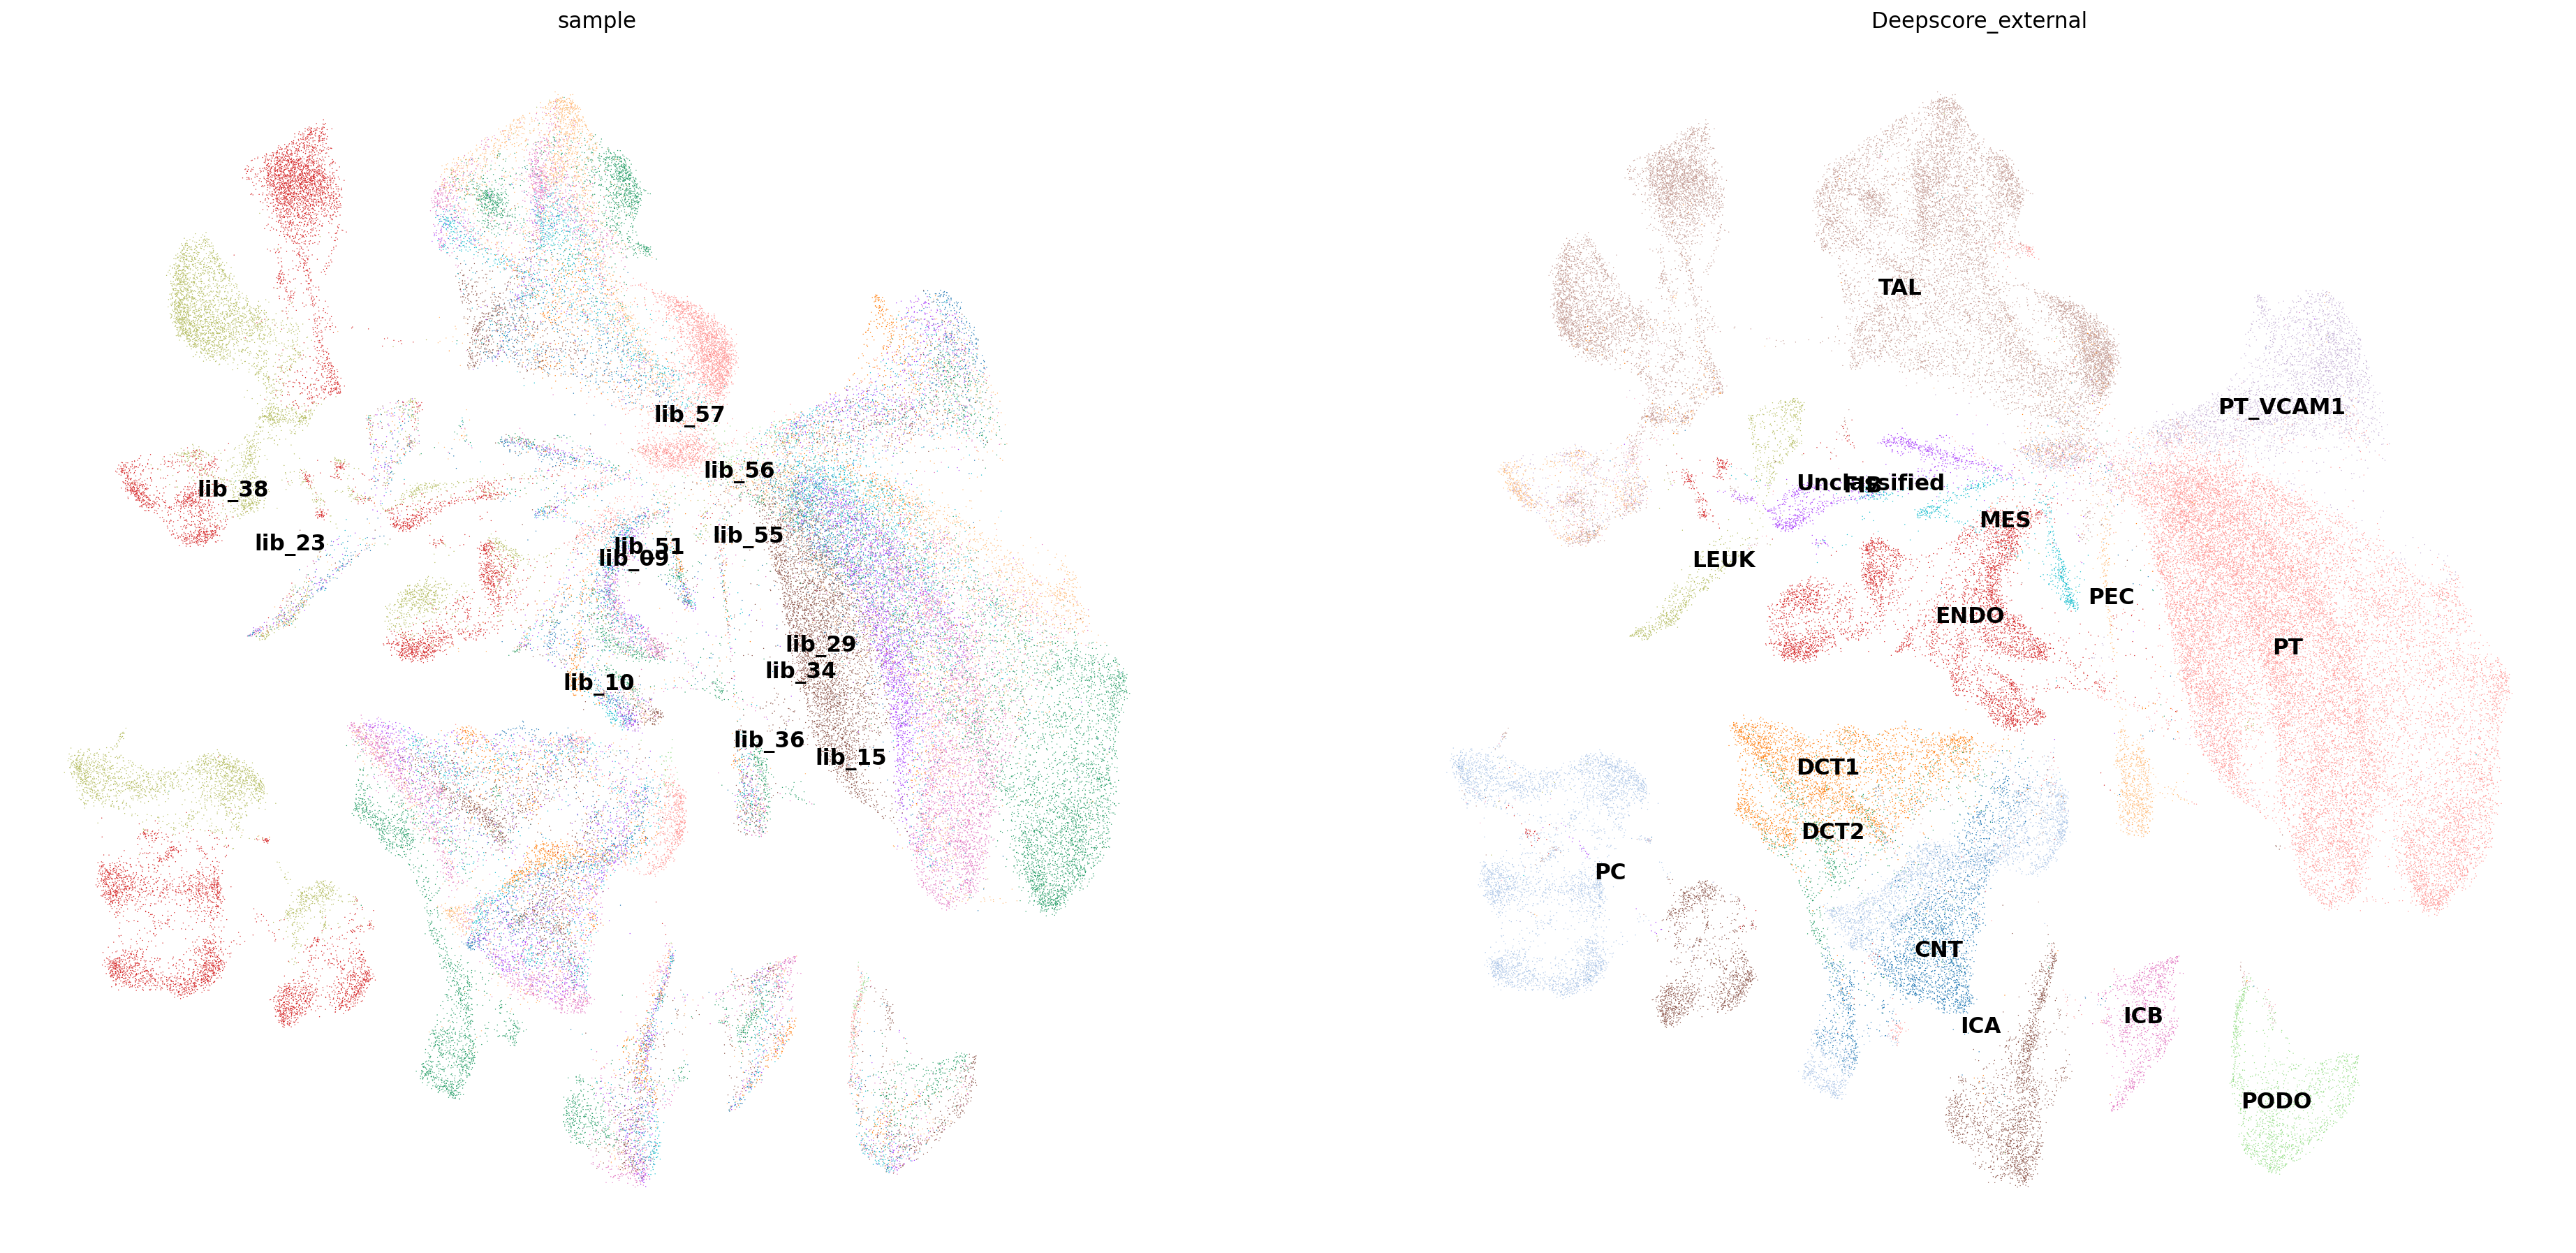

In [27]:
rcParams['figure.figsize'] = (14,14)

sc.pl.umap(adata, color = ['sample','Deepscore_external'], legend_loc='on data', frameon = False)


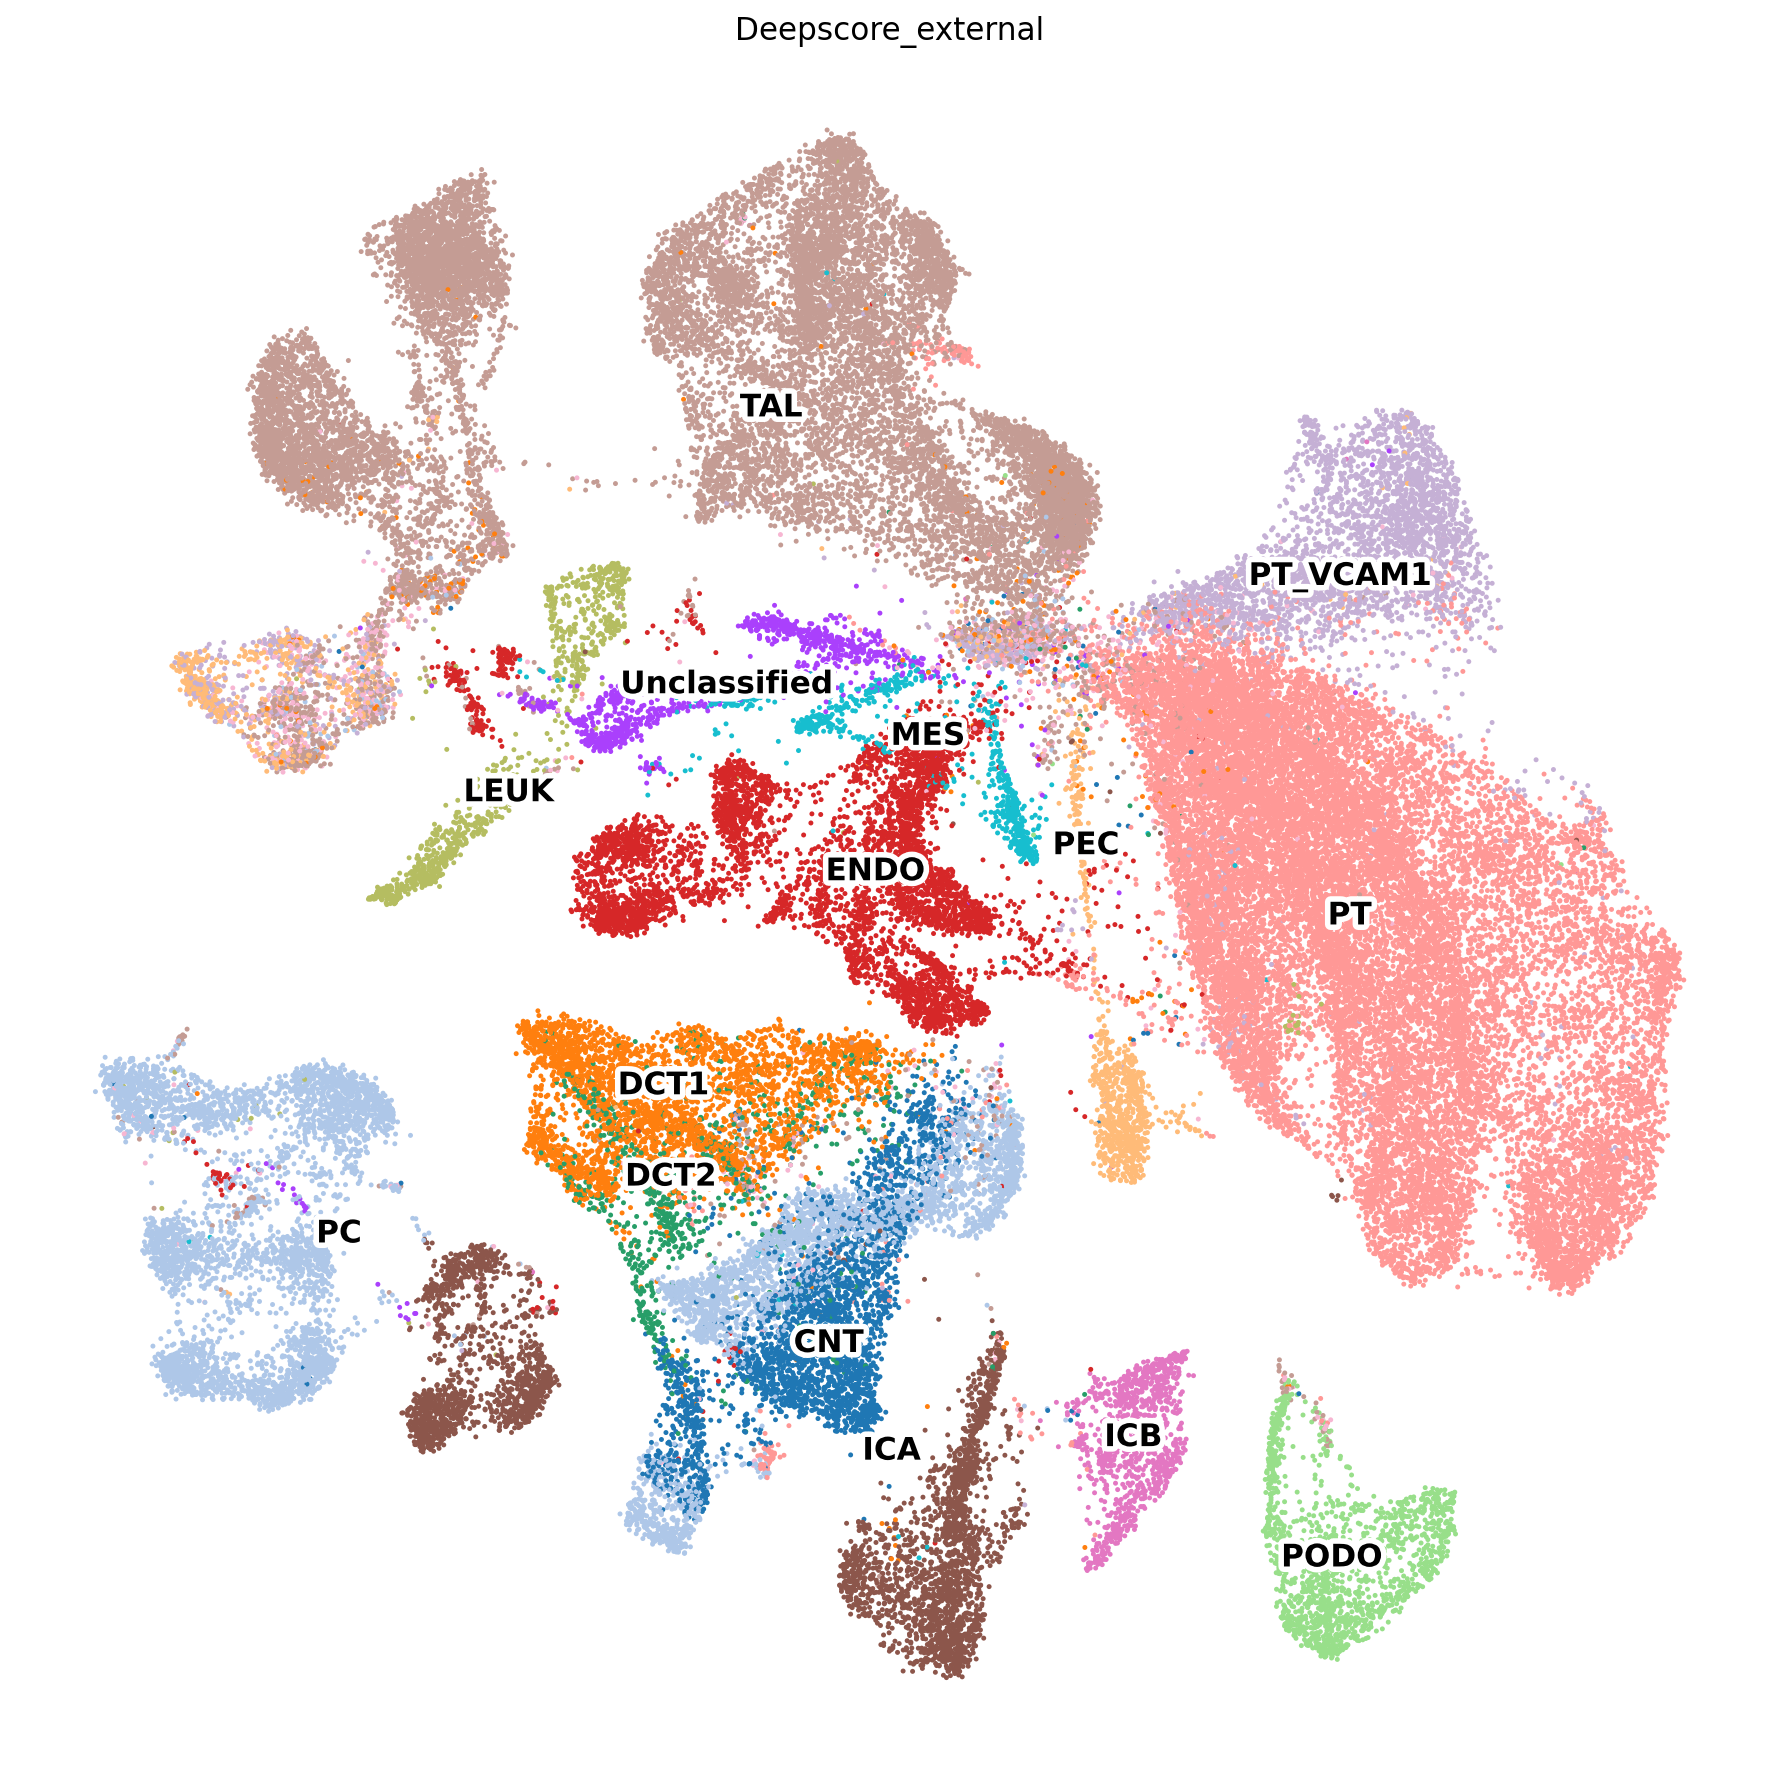

In [30]:

sc.pl.umap(adata, color = ['Deepscore_external'],size = 20, legend_loc='on data',legend_fontoutline=5, frameon = False)


In [25]:
adata.write(f'objects/Deepscore_markers.h5ad', compression = 'gzip')
